# Ennustekone

Tämä versio soveltuu paremmin kokeilujen tekemiseen, sillä uuden ennusteen voi tehdä ajamalla vain yhden koodilohkon. Koodattu erityisen "quick n dirty". Esikäsittelijän alle on lisätty muutamia funktioita käytettäväksi tässä.

In [1]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import importlib.util
import sys
file_path = "../../Tehtava-03/preprocessor.py"; module_name = "preprocessor"; spec = importlib.util.spec_from_file_location(module_name, file_path)
esik = importlib.util.module_from_spec(spec); sys.modules[module_name] = esik; spec.loader.exec_module(esik)


In [2]:
customer_segment = 'customer_segment'
cols = ['installation_date', customer_segment]
df_all = esik.esik(cols)


In [3]:
df = df_all.copy()
# Valitaan tarkasteltava asiakasryhmä
df = df[df[customer_segment] == 'RES']
df.drop([customer_segment], axis=1, inplace=True)

freq = 'M'
time_format = '%Y-%m'

df_ts = esik.tsp.get_timeserie(df, freq, time_format)
#display(df_ts)

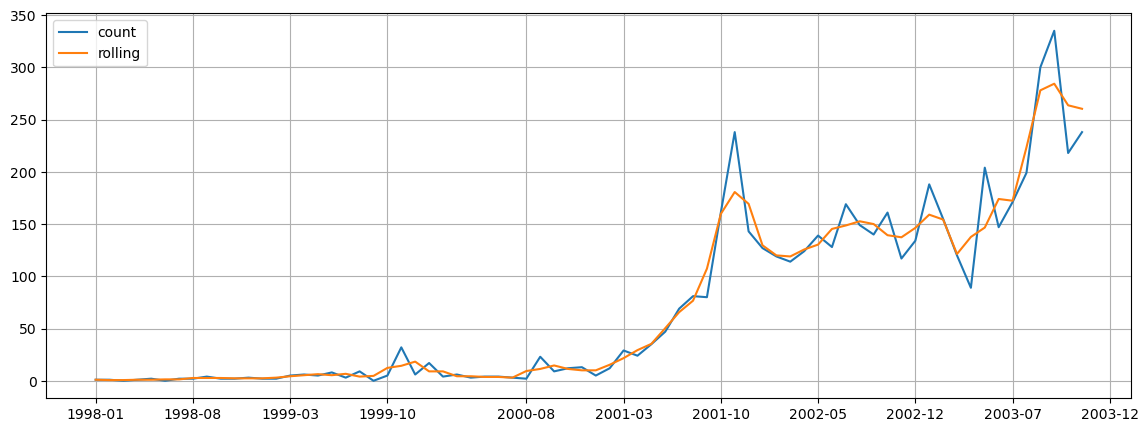

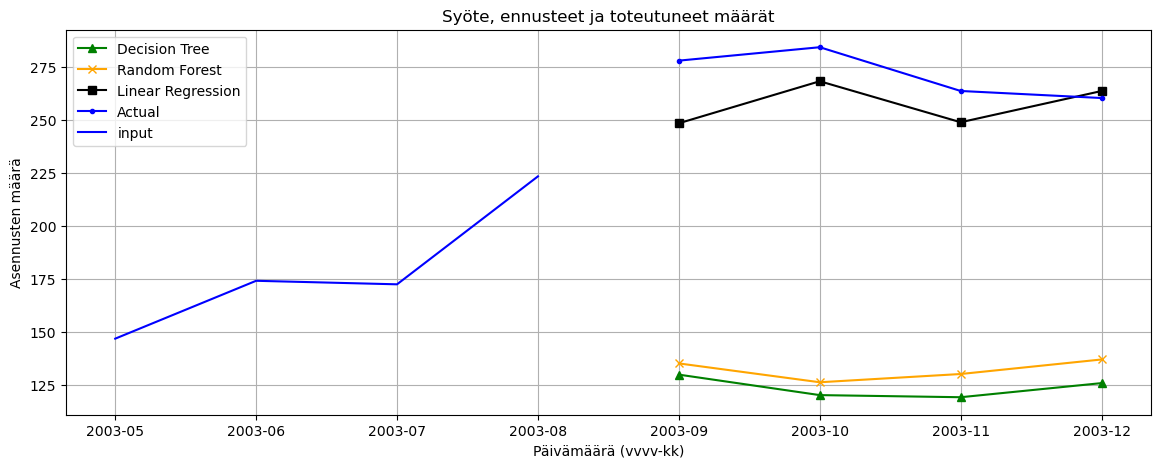

In [4]:
start = '1998-01-01'
end = '2003-12-28'

input_len = 4
output_len = 4

rolling_periods = 3  # Kuinka monesta arvosta liukuva keskiarvo lasketaan

df_ML = esik.tsp.get_df_ML(df_ts, start, end, freq, time_format, rolling_periods)
X_train, X_test, y_train, y_test, test_size, N = esik.tsp.seq_train_test_split(input_len, output_len, df_ML)

# Koneoppimisalgoritmit
dt_seq = DecisionTreeRegressor(random_state=9)
dt_seq.fit(X_train, y_train)
dt_seq_preds = dt_seq.predict(X_test)

rf_seq = RandomForestRegressor(random_state=9)
rf_seq.fit(X_train, y_train)
rf_seq_preds = rf_seq.predict(X_test)

lr_seq = LinearRegression()
lr_seq.fit(X_train, y_train)
lr_seq_preds = lr_seq.predict(X_test)

# Apumuuttujia
x_ticks_range = pd.period_range(start=start, end='2023-12-01', freq=freq).strftime(time_format)
a = input_len; b = input_len + output_len
def format_date_2(x1, pos=None):
  thisind = np.clip(int(x1 + 0.5), 0, N - 1)
  return x_ticks_range[N - test_size + thisind]

# Piirto
fig, ax = esik.tsp.plt.subplots(figsize=(14, 5))
ax.plot(np.arange(a, b, 1), dt_seq_preds[0], marker='^', color='green', label='Decision Tree')
ax.plot(np.arange(a, b, 1), rf_seq_preds[0], marker='x', color='orange', label='Random Forest')
ax.plot(np.arange(a, b, 1), lr_seq_preds[0], marker='s', color='black', label='Linear Regression')
ax.plot(np.arange(a, b, 1), y_test[0], marker='.', color='blue', label='Actual')
ax.plot(np.arange(0, a, 1), X_test[0], 'b-', label='input')

locator = esik.tsp.mdates.AutoDateLocator(minticks=4, maxticks=16)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(format_date_2)
#fig.autofmt_xdate()
ax.set_xlabel('Päivämäärä (vvvv-kk)')
ax.set_ylabel('Asennusten määrä')
ax.set_title('Syöte, ennusteet ja toteutuneet määrät')
ax.legend()
ax.grid()
esik.tsp.plt.show()


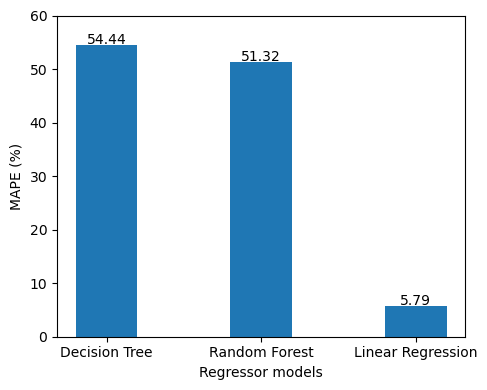

In [5]:
def mape(y_true, y_pred):
  return round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 2)

dt_mape = mape(y_test[0], dt_seq_preds[0])
rf_mape = mape(y_test[0], rf_seq_preds[0])
lr_mape = mape(y_test[0], lr_seq_preds[0])

# Generate bar plot
fig, ax = esik.tsp.plt.subplots(figsize=(5, 4))
x = ['Decision Tree', 'Random Forest', 'Linear Regression']
y = [dt_mape, rf_mape, lr_mape]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Regressor models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, int(np.array(y).max() * 1.1 + 1))

for index, value in enumerate(y):
  esik.tsp.plt.text(x=index, y=value + 0.2, s=str(value), ha='center')

esik.tsp.plt.tight_layout()